In [140]:
#import all required libraries
#Data Analysis
import pandas as pd
import numpy as np
import json
#Visulaization libraries
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.palettes import Viridis5
import seaborn as sns
import matplotlib.pyplot as plt

#model developemnt libraries
from sklearn import preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

from sklearn.metrics import classification_report
#Bias Mitigation libraries

from IPython.display import Markdown, display

#
from IPython.display import SVG, display
import warnings
warnings.filterwarnings("ignore")
#deployment library
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pygal
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

In [141]:
import sklearn
#from sklearn.cross_validation import train_test_split

In [4]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

ModuleNotFoundError: No module named 'watson_machine_learning_client'

In [184]:
df_data = pd.read_excel("D:/USUARIS/ALVTGTP/Desktop/ML/FastPlanTot/BECDDBB.xlsx",index_col=0)

In [ ]:
df_data.head()

In [146]:
df_data.describe(include = 'all')

,Gender,Age,Education,Area,Nationality,Center,Linea,Contracted
count,1316,1316.000000,1316,1316,1316,1316,1316.000000,1316.000000
unique,2,NaN,11,2,42,9,NaN,NaN
top,V,NaN,Graduado,V,ES,MRT,NaN,NaN
freq,815,NaN,1023,815,859,981,NaN,NaN
mean,NaN,24.359422,NaN,NaN,NaN,NaN,0.768237,0.085866
std,NaN,3.346980,NaN,NaN,NaN,NaN,0.422119,0.280273
min,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,NaN,22.750000,NaN,NaN,NaN,NaN,1.000000,0.000000
50%,NaN,24.000000,NaN,NaN,NaN,NaN,1.000000,0.000000
75%,NaN,26.000000,NaN,NaN,NaN,NaN,1.000000,0.000000


In [185]:
df_data.isnull().sum()

Gender         0
Age            0
Education      0
Area           0
Nationality    0
Center         0
Linea          0
Contracted     0
dtype: int64

In [186]:
df_data['DENO_CONTR'].unique()

KeyError: 'DENO_CONTR'

In [189]:
categorical = df_data.select_dtypes(include=['object']).columns.tolist()
categorical

['Gender', 'Education', 'Area', 'Nationality', 'Center']

In [188]:
#df_data = pd.get_dummies(df_data, columns= categorical_feats)

In [190]:
#Deep copy the original data
data_encoded = df_data.copy(deep=True)
#Use Scikit-learn label encoding to encode character data
lab_enc = preprocessing.LabelEncoder()
for col in categorical:
        data_encoded[col] = lab_enc.fit_transform(df_data[col])
        le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
        print('Feature', col)
        print('mapping', le_name_mapping)

Feature Gender
mapping {'M': 0, 'V': 1}
Feature Education
mapping {'Curso Externo': 0, 'Diplomado': 1, 'Estudios Secundarios': 2, 'Formación Profesional Media': 3, 'Formación Profesional Superior': 4, 'Graduado': 5, 'Ingeniero': 6, 'Ingeniero Técnico': 7, 'Licenciado': 8, 'Postgrado / Master': 9, 'Sin título': 10}
Feature Area
mapping {'B': 0, 'E': 1, 'F': 2, 'G': 3, 'L': 4, 'P': 5, 'R': 6, 'S': 7, 'SS': 8, 'V': 9, 'XM': 10}
Feature Nationality
mapping {'AD': 0, 'AR': 1, 'AT': 2, 'AZ': 3, 'BE': 4, 'BG': 5, 'BO': 6, 'BR': 7, 'BY': 8, 'CA': 9, 'CH': 10, 'CL': 11, 'CN': 12, 'CO': 13, 'CZ': 14, 'DE': 15, 'DM': 16, 'EC': 17, 'ES': 18, 'FI': 19, 'FK': 20, 'FR': 21, 'GT': 22, 'HN': 23, 'IL': 24, 'IR': 25, 'IT': 26, 'MA': 27, 'MO': 28, 'MX': 29, 'NI': 30, 'NL': 31, 'PE': 32, 'PK': 33, 'PT': 34, 'RO': 35, 'RU': 36, 'SK': 37, 'SV': 38, 'TR': 39, 'US': 40, 'VE': 41}
Feature Center
mapping {'ACR': 0, 'BRC': 1, 'CTS': 2, 'MDR': 3, 'MRT': 4, 'SCO': 5, 'SSP': 6, 'VLD': 7, 'XMO': 8}


In [191]:
data_correlation = data_encoded.corr()

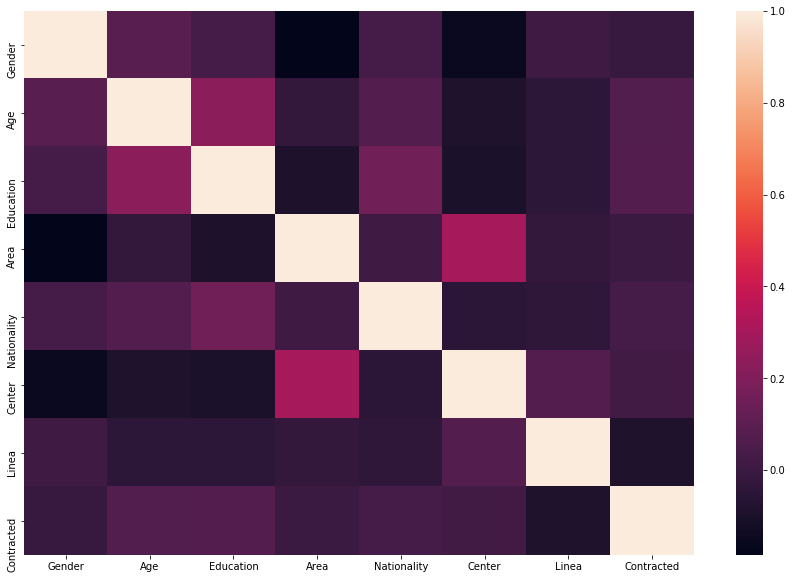

In [192]:
plt.rcParams["figure.figsize"] = [15,10]
sns.heatmap(data_correlation,xticklabels=data_correlation.columns,yticklabels=data_correlation.columns)

(array([   2.,   14., 1236.,   53.,   11.,    0.,    0.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70]),
 <a list of 7 Patch objects>)

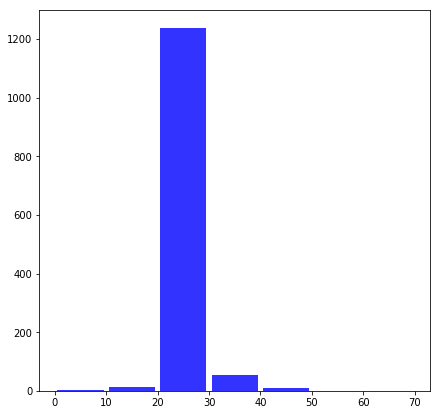

In [193]:
#Plot to see distribution of age overall
plt.rcParams["figure.figsize"] = [7,7]
plt.hist(data_encoded['Age'], bins=np.arange(0,80,10), alpha=0.8, rwidth=0.9, color='blue')

In [194]:
#We are going to bin age (multiples of 10) to see which age group are likely to leave the company.
#Before that, let us take only employee who are likely to quit.
positive_attrition_df = data_encoded.loc[data_encoded['Contracted'] == 1]
negative_attrition_df = data_encoded.loc[data_encoded['Contracted'] == 0]

(array([  0.,   1., 103.,   8.,   1.,   0.,   0.]),
 array([ 0, 10, 20, 30, 40, 50, 60, 70]),
 <a list of 7 Patch objects>)

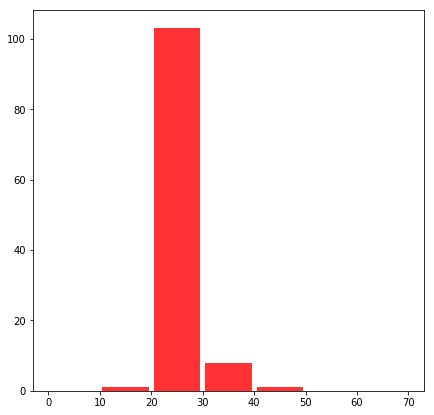

In [195]:
plt.hist(positive_attrition_df['Age'], bins=np.arange(0,80,10), alpha=0.8, rwidth=0.9, color='red')

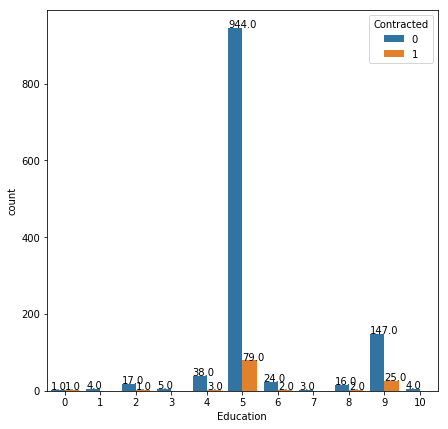

In [196]:
ax = sns.countplot(x="Education", hue="Contracted", data=data_encoded)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+1))

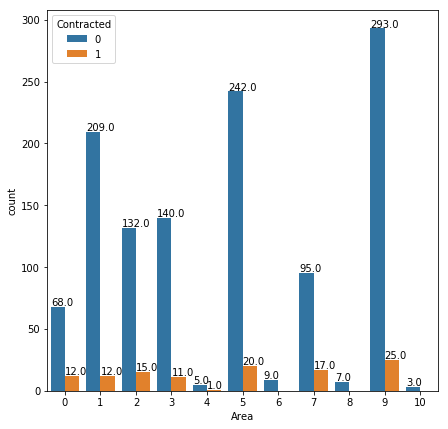

In [197]:
ax = sns.countplot(x="Area", hue="Contracted", data=data_encoded)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()+1))

In [70]:
#analyzing employees who has positive attrition
init_notebook_mode(connected=True)
cf.go_offline()
positive_attrition_df['MaritalStatus'].value_counts().iplot(kind='bar')

In [164]:
df_age = data_encoded.copy(deep=True)
df_age.loc[df_age['Age'] <= 20, 'Age'] = 0
df_age.loc[(df_age['Age'] > 20) & (df_age['Age'] <= 30), 'Age'] = 1
df_age.loc[(df_age['Age'] > 30) & (df_age['Age'] <= 40), 'Age'] = 2
df_age.loc[(df_age['Age'] > 40) & (df_age['Age'] <= 50), 'Age'] = 3
df_age.loc[(df_age['Age'] > 50), 'Age'] = 4

In [165]:
df_age = pd.DataFrame({'count': df_age.groupby(["Gender", "Contracted"]).size()}).reset_index()
df_age['Gender-Contracted'] = df_age['Gender'].astype(str) + "-" + df_age['Contracted'].astype(str).map(str)

In [166]:
df_age

,Gender,Contracted,count,Gender-Contracted
0,0,0,456,0-0
1,0,1,45,0-1
2,1,0,747,1-0
3,1,1,68,1-1


In [170]:
output_notebook() 

# x and y axes
Gender_Attrition = df_age['Gender-Contracted'].tolist()
count = df_age['count'].tolist()

print(count)

# Bokeh's mapping of column names and data lists
source = ColumnDataSource(data=dict(Gender_Attrition=Gender_Attrition, count=count, color=Viridis5))

plot_bar = figure(x_range=Gender_Attrition, plot_height=350, title="Counts")

# Render and show the vbar plot
plot_bar.vbar(x='Gender-Contracted', top='count', width=0.9, color='color', source=source)
show(plot_bar)

SyntaxError: keyword can't be an expression (<ipython-input-170-0537e323e3b0>, line 10)

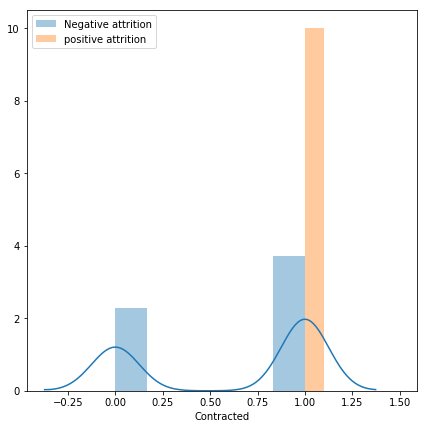

In [172]:
sns.distplot(negative_attrition_df['Area'], label='Negative attrition')
sns.distplot(positive_attrition_df['Contracted'], label='positive attrition')
plt.legend()

In [198]:
input_data = data_encoded.drop(['Contracted'], axis=1)

In [199]:
target_data = data_encoded[['Contracted']]

In [200]:
input_data.columns

Index(['Gender', 'Age', 'Education', 'Area', 'Nationality', 'Center', 'Linea'], dtype='object')

In [201]:
col_values = list(input_data.columns.values)
#gives top 10 features having maximum mutual information value
feature_scores = mutual_info_classif(input_data, target_data)
for score, fname in sorted(zip(feature_scores, col_values), reverse=True)[:10]:
    print(fname, score)

Age 0.022395222789175717
Nationality 0.018499937672523226
Linea 0.008492574623832017
Area 0.000241150280550384
Gender 0.0
Education 0.0
Center 0.0


In [209]:
#gives top 10 features having maximum chi-square value
feature_scores = chi2(input_data, target_data)[0]
a = []
for score, fname in sorted(zip(feature_scores, col_values), reverse=True)[:10]:
    print(fname, score)
    a.append(fname)


Age 2.8974144667745487
Education 2.8242452200256674
Linea 2.403552499608742
Nationality 1.6772742241154546
Center 0.2109112325033018
Gender 0.06134517119438776
Area 0.00012684440214095333


In [210]:
data_selected = df_data

In [212]:
#encoding labels
data_selected.loc[data_selected.Contracted == 'No', 'Contracted'] = 0
data_selected.loc[data_selected.Contracted == 'Yes', 'Contracted'] = 1

In [213]:
input_data = data_selected.drop(['Contracted'], axis=1)
target_data = data_selected[['Contracted']]

In [214]:
input_data.shape

(1316, 7)

In [237]:
input_data = data_selected[0:1000]
print('Shape of the input data is ', input_data.shape)
input_data['Contracted'].value_counts()

Shape of the input data is  (1000, 8)


0    933
1     67
Name: Contracted, dtype: int64

In [238]:
validation_data = data_selected[1000:1316]
print('Shape of the validation data is ', validation_data.shape)
validation_input_data = validation_data.drop(['Contracted'], axis=1)
print('Shape of the validation input data is ', validation_input_data.shape)
validation_target_data = validation_data[['Contracted']]
print('Shape of the validation target data is ', validation_target_data.shape)

Shape of the validation data is  (316, 8)
Shape of the validation input data is  (316, 7)
Shape of the validation target data is  (316, 1)


In [240]:
#Using 1 sample as test data to check deployment
test_data = pd.read_excel("D:/USUARIS/ALVTGTP/Desktop/ML/FastPlanTot/BECDDBB.xlsx",index_col=0,sheet_name = "test")
print(test_data)
print('Shape of the test data is ', test_data.shape)
test_input_data = test_data.drop(['Contracted'], axis=1)
print('Shape of the test input data is ', test_input_data.shape)
test_target_data = test_data[['Contracted']]
print('Shape of the test target data is ', test_target_data.shape)

      Gender  Age                                 Education Area Nationality  \
NIS                                                                            
69948      M   24                        Bachiller Superior    V          ES   
71021      M   22                  BUP / Bachillerato Logse    G          ES   
71524      V   25     Graduado Ing. de Tecnol. Industriales    P          ES   
72252      M   24  Grad. Negocios/Marketing Internacionales    V          ES   
72456      M   25                       Graduado en Derecho    L          ES   
72457      M   25           Graduado en Ingeniería Mecánica    G          ES   
72582      V   24     Graduado Ing. de Tecnol. Industriales    P          ES   
72603      M   24     Graduado Ing. de Tecnol. Industriales    P          ES   
72626      M   25      Graduado en Criminología y Seguridad    G          ES   
72631      V   24          Graduado en Ciencias Ambientales    V          ES   
72632      M   23  Graduado Adminis. y D

KeyError: "['Contracted'] not found in axis"

In [220]:
b = a.copy()
b.remove('Contracted')
b

ValueError: list.remove(x): x not in list

In [241]:
#categorical = ["Department","Education","Gender","MaritalStatus","Tipo Contr","Rel_Con","MonthlyIncome"]
#encoding training and validation data. 
#custom label encoder library
from Pipeline_LabelEncoder.sklearn_label_encoder import PipelineLabelEncoder
preprocessed_data = PipelineLabelEncoder(columns = a).fit_transform(input_data)
print('-------------------------')
print('validation data encoding')
validation_enc_data = PipelineLabelEncoder(columns = a).transform(validation_input_data)

Inside fit transform
Feature Age
mapping {0: 0, 17: 1, 18: 2, 19: 3, 20: 4, 21: 5, 22: 6, 23: 7, 24: 8, 25: 9, 26: 10, 27: 11, 28: 12, 29: 13, 30: 14, 31: 15, 32: 16, 33: 17, 34: 18, 41: 19, 43: 20, 44: 21, 45: 22, 46: 23, 48: 24, 49: 25}
Feature Education
mapping {'Curso Externo': 0, 'Diplomado': 1, 'Estudios Secundarios': 2, 'Formación Profesional Media': 3, 'Formación Profesional Superior': 4, 'Graduado': 5, 'Ingeniero': 6, 'Licenciado': 7, 'Postgrado / Master': 8, 'Sin título': 9}
Feature Linea
mapping {0: 0, 1: 1}
Feature Nationality
mapping {'AD': 0, 'AR': 1, 'AT': 2, 'AZ': 3, 'BE': 4, 'BG': 5, 'BO': 6, 'BR': 7, 'BY': 8, 'CA': 9, 'CH': 10, 'CL': 11, 'CN': 12, 'CO': 13, 'CZ': 14, 'DE': 15, 'DM': 16, 'EC': 17, 'ES': 18, 'FI': 19, 'FK': 20, 'FR': 21, 'GT': 22, 'HN': 23, 'IL': 24, 'IR': 25, 'IT': 26, 'MA': 27, 'MO': 28, 'MX': 29, 'NI': 30, 'NL': 31, 'PE': 32, 'PK': 33, 'PT': 34, 'RU': 35, 'SV': 36, 'TR': 37, 'US': 38, 'VE': 39}
Feature Center
mapping {'ACR': 0, 'BRC': 1, 'CTS': 2, 'M

In [242]:
# Gender is the protected attribute. 
#label 0: Employee will stay 
#label 1: Employee will leave
# Gender 0: Female and Gender 1: Male
privileged_groups = [{'Gender': 0}]
unprivileged_groups = [{'Gender': 1}]
favorable_label = 0 
unfavorable_label = 1

In [243]:
preprocessed_data.columns.unique()

Index(['Gender', 'Age', 'Education', 'Area', 'Nationality', 'Center', 'Linea',
       'Contracted'],
      dtype='object')

In [244]:
#Create binary label dataset that can be used by bias mitigation algorithms
BM_dataset = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=preprocessed_data,
                                label_names=['Contracted'],
                                protected_attribute_names=['Gender'],
                                unprivileged_protected_attributes=unprivileged_groups)

In [245]:
display(Markdown("#### Training Data Details"))
print("shape of the training dataset", BM_dataset.features.shape)
print("Training data favorable label", BM_dataset.favorable_label)
print("Training data unfavorable label", BM_dataset.unfavorable_label)
print("Training data protected attribute", BM_dataset.protected_attribute_names)
print("Training data privileged protected attribute (1:Male and 0:Female)", 
      BM_dataset.privileged_protected_attributes)
print("Training data unprivileged protected attribute (1:Male and 0:Female)",
      BM_dataset.unprivileged_protected_attributes)

#### Training Data Details

shape of the training dataset (1000, 7)
Training data favorable label 0.0
Training data unfavorable label 1.0
Training data protected attribute ['Gender']
Training data privileged protected attribute (1:Male and 0:Female) [array([1.])]
Training data unprivileged protected attribute (1:Male and 0:Female) [array([0.])]


In [246]:
metric_orig_train = BinaryLabelDatasetMetric(BM_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.012267


In [247]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(BM_dataset)
train_tf_dataset = RW.transform(BM_dataset)

In [248]:
train_tf_dataset.labels

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [249]:
metric_orig_train = BinaryLabelDatasetMetric(train_tf_dataset, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Difference in mean outcomes between unprivileged and privileged groups = %f"
      % metric_orig_train.mean_difference())

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [250]:
#n_estimators is the maximum number of estimators at which the boosting is terminated. Default is 50 and this can be tuned as well.
cls = AdaBoostClassifier(n_estimators=100)

In [251]:
#finding best estimator
#tune other parameters for better accuracy
estimator = [100, 150, 200, 250, 300, 400, 500, 700, 1000]
for i in estimator:
    cls = AdaBoostClassifier(n_estimators=i)
    cls.fit(train_tf_dataset.features, train_tf_dataset.labels,sample_weight=train_tf_dataset.instance_weights)
    print('--------------------------------------------------------------------------------------------')
    print('------    Training Results for {} estimators   ---------'.format(i))
    predicted_output = cls.predict(train_tf_dataset.features)
    accuracy = metrics.accuracy_score(train_tf_dataset.labels, predicted_output)
    print('Accuracy for {} estimators is {}'.format(i, accuracy))
    print(classification_report(train_tf_dataset.labels, predicted_output))
    print('------    Test Results for {} estimators   ---------'.format(i))
    predicted_output = cls.predict(validation_enc_data)
    accuracy = metrics.accuracy_score(validation_target_data, predicted_output)
    print('Accuracy for {} estimators is {}'.format(i, accuracy))
    print(classification_report(validation_target_data, predicted_output))
    print('--------------------------------------------------------------------------------------------')

--------------------------------------------------------------------------------------------
------    Training Results for 100 estimators   ---------
Accuracy for 100 estimators is 0.938
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       933
         1.0       0.86      0.09      0.16        67

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.90      0.54      0.56      1000
weighted avg       0.93      0.94      0.91      1000

------    Test Results for 100 estimators   ---------
Accuracy for 100 estimators is 0.8544303797468354
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       270
           1       0.00      0.00      0.00        46

   micro avg       0.85      0.85      0.85       316
   macro avg       0.43      0.50      0.46       316
weighted avg       0.73      0.85      0.79       316

------------------------------------------------------

--------------------------------------------------------------------------------------------
------    Training Results for 1000 estimators   ---------
Accuracy for 1000 estimators is 0.937
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97       933
         1.0       0.75      0.09      0.16        67

   micro avg       0.94      0.94      0.94      1000
   macro avg       0.84      0.54      0.56      1000
weighted avg       0.93      0.94      0.91      1000

------    Test Results for 1000 estimators   ---------
Accuracy for 1000 estimators is 0.8544303797468354
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       270
           1       0.00      0.00      0.00        46

   micro avg       0.85      0.85      0.85       316
   macro avg       0.43      0.50      0.46       316
weighted avg       0.73      0.85      0.79       316

--------------------------------------------------

In [252]:
#Choose the best estimator value from above and replace the 'num_of_estimators' with the value.
num_of_estimators = 400
cls = AdaBoostClassifier(n_estimators=num_of_estimators)
cls.fit(train_tf_dataset.features, train_tf_dataset.labels,sample_weight=train_tf_dataset.instance_weights)
#Creating model pipeline
test_pp = PipelineLabelEncoder(columns = b)
model_pipeline = Pipeline(steps=[('preprocessor', test_pp), 
                       ('classifier', cls)])

In [253]:
model_pipeline.predict(test_input_data)

Feature Age
mapping {0: 0, 17: 1, 18: 2, 19: 3, 20: 4, 21: 5, 22: 6, 23: 7, 24: 8, 25: 9, 26: 10, 27: 11, 28: 12, 29: 13, 30: 14, 31: 15, 32: 16, 33: 17, 34: 18, 36: 19, 41: 20, 43: 21, 44: 22, 45: 23, 46: 24, 48: 25, 49: 26}
Feature Education
mapping {'Curso Externo': 0, 'Diplomado': 1, 'Estudios Secundarios': 2, 'Formación Profesional Media': 3, 'Formación Profesional Superior': 4, 'Graduado': 5, 'Ingeniero': 6, 'Ingeniero Técnico': 7, 'Licenciado': 8, 'Postgrado / Master': 9, 'Sin título': 10}
Feature Linea
mapping {0: 0, 1: 1}
Feature Nationality
mapping {'AD': 0, 'AR': 1, 'AT': 2, 'AZ': 3, 'BE': 4, 'BG': 5, 'BO': 6, 'BR': 7, 'BY': 8, 'CA': 9, 'CH': 10, 'CL': 11, 'CN': 12, 'CO': 13, 'CZ': 14, 'DE': 15, 'DM': 16, 'EC': 17, 'ES': 18, 'FI': 19, 'FK': 20, 'FR': 21, 'GT': 22, 'HN': 23, 'IL': 24, 'IR': 25, 'IT': 26, 'MA': 27, 'MO': 28, 'MX': 29, 'NI': 30, 'NL': 31, 'PE': 32, 'PK': 33, 'PT': 34, 'RO': 35, 'RU': 36, 'SK': 37, 'SV': 38, 'TR': 39, 'US': 40, 'VE': 41}
Feature Center
mapping {

ValueError: Number of features of the model must match the input. Model n_features is 7 and input n_features is 8 

In [254]:
final_pred = model_pipeline.predict_proba(test_input_data)

Feature Age
mapping {0: 0, 17: 1, 18: 2, 19: 3, 20: 4, 21: 5, 22: 6, 23: 7, 24: 8, 25: 9, 26: 10, 27: 11, 28: 12, 29: 13, 30: 14, 31: 15, 32: 16, 33: 17, 34: 18, 36: 19, 41: 20, 43: 21, 44: 22, 45: 23, 46: 24, 48: 25, 49: 26}
Feature Education
mapping {'Curso Externo': 0, 'Diplomado': 1, 'Estudios Secundarios': 2, 'Formación Profesional Media': 3, 'Formación Profesional Superior': 4, 'Graduado': 5, 'Ingeniero': 6, 'Ingeniero Técnico': 7, 'Licenciado': 8, 'Postgrado / Master': 9, 'Sin título': 10}
Feature Linea
mapping {0: 0, 1: 1}
Feature Nationality
mapping {'AD': 0, 'AR': 1, 'AT': 2, 'AZ': 3, 'BE': 4, 'BG': 5, 'BO': 6, 'BR': 7, 'BY': 8, 'CA': 9, 'CH': 10, 'CL': 11, 'CN': 12, 'CO': 13, 'CZ': 14, 'DE': 15, 'DM': 16, 'EC': 17, 'ES': 18, 'FI': 19, 'FK': 20, 'FR': 21, 'GT': 22, 'HN': 23, 'IL': 24, 'IR': 25, 'IT': 26, 'MA': 27, 'MO': 28, 'MX': 29, 'NI': 30, 'NL': 31, 'PE': 32, 'PK': 33, 'PT': 34, 'RO': 35, 'RU': 36, 'SK': 37, 'SV': 38, 'TR': 39, 'US': 40, 'VE': 41}
Feature Center
mapping {

ValueError: Number of features of the model must match the input. Model n_features is 7 and input n_features is 8 

In [235]:
final = test_input_data
final['pred'] = final_pred[:,1]

In [236]:
final.to_excel("becs.xlsx",index=True)